In [ ]:
!pip install transformers

In [ ]:
from google.colab import drive
import torch
import matplotlib.pyplot as plt
import pandas as pd

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification
import torch.optim as optim

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
raw_data_path = "/content/drive/My Drive/Colab Notebooks/Fake Real Tweets/news.csv"
destination_folder = "/content/drive/My Drive/Colab Notebooks/Fake Real Tweets"

train_test_ratio = 0.10
train_valid_ratio = 0.80

first_n_words = 200

In [ ]:
def trim_string(x):
  x = x.split(maxsplit=first_n_words)
  x = ' '.join(x[:first_n_words])
  return x

In [ ]:
# Read raw data
df_raw = pd.read_csv(raw_data_path)

# Prepare columns
df_raw['label'] = (df_raw['label'] == 'FAKE').astype('int')
df_raw['titletext'] = df_raw['title'] + ". " + df_raw['text']
df_raw = df_raw.reindex(columns=['label', 'title', 'text', 'titletext'])

# Drop rows with empty text
df_raw.drop( df_raw[df_raw.text.str.len() < 5].index, inplace=True)

# Trim text and titletext to first_n_words
df_raw['text'] = df_raw['text'].apply(trim_string)
df_raw['titletext'] = df_raw['titletext'].apply(trim_string) 

# Split according to label
df_real = df_raw[df_raw['label'] == 0]
df_fake = df_raw[df_raw['label'] == 1]

# Train-test split
df_real_full_train, df_real_test = train_test_split(df_real, train_size = train_test_ratio, random_state = 1)
df_fake_full_train, df_fake_test = train_test_split(df_fake, train_size = train_test_ratio, random_state = 1)

# Train-valid split
df_real_train, df_real_valid = train_test_split(df_real_full_train, train_size = train_valid_ratio, random_state = 1)
df_fake_train, df_fake_valid = train_test_split(df_fake_full_train, train_size = train_valid_ratio, random_state = 1)

# Concatenate splits of different labels
df_train = pd.concat([df_real_train, df_fake_train], ignore_index=True, sort=False)
df_valid = pd.concat([df_real_valid, df_fake_valid], ignore_index=True, sort=False)
df_test = pd.concat([df_real_test, df_fake_test], ignore_index=True, sort=False)

# Write preprocessed data
df_train.to_csv(destination_folder + '/train.csv', index=False)
df_valid.to_csv(destination_folder + '/valid.csv', index=False)
df_test.to_csv(destination_folder + '/test.csv', index=False)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#Model Parameters
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

#Fields
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('label', label_field), ('title', text_field), ('text', text_field), ('titletext', text_field)]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#Data preprocess
train, valid, test = TabularDataset.splits(path=destination_folder,train='train.csv', validation='valid.csv',
                                           test='test.csv', format='CSV', fields=fields, skip_header=True)
train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

Token indices sequence length is longer than the specified maximum sequence length for this model (704 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (719 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (864 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (883 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4228 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

In [ ]:
class BERT(nn.Module):
  def __init__(self):
    super(BERT, self).__init__()
    options_name = "bert-base-uncased"
    self.encoder = BertForSequenceClassification.from_pretrained(options_name)
  
  def forward(self, text, label):
    loss, text_fea = self.encoder(text, labels=label)[:2]
    return loss, text_fea

In [ ]:
#Save load functions
def save_checkpoint(save_path, model, valid_loss):

  if save_path == None:
    return
  state_dict = {'model_state_dict':model.state_dict(), 'valid_loss':valid_loss}
  torch.save(state_dict, save_path)
  print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
  if load_path==None:
    return
  state_dict = torch.load(load_path, map_location=device)
  print(f'Model loaded from <== {load_path}')
  model.load_state_dict(state_dict['model_state_dict'])
  return state_dict['valid_loss']

def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):
  if save_path == None:
      return
  state_dict = {'train_loss_list': train_loss_list,
                'valid_loss_list': valid_loss_list,
                'global_steps_list': global_steps_list}
  torch.save(state_dict, save_path)
  print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):
  if load_path==None:
      return
  state_dict = torch.load(load_path, map_location=device)
  print(f'Model loaded from <== {load_path}')
  return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [ ]:
def train(model, optimizer, 
          criterion = nn.BCELoss(), 
          train_loader=train_iter, 
          valid_loader= valid_iter, 
          num_epochs=5, 
          eval_every = len(train_iter)//2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
  running_loss = 0.0
  valid_running_loss = 0.0
  global_step = 0
  train_loss_list = []
  valid_loss_list = []
  global_steps_list = []
  sigm = nn.Sigmoid()
  model.train()
  for epoch in range(num_epochs):
    for (labels, title, text, titletext), _ in train_loader:
      labels  = labels.type(torch.LongTensor)
      labels = labels.to(device)
      titletext = titletext.type(torch.LongTensor)
      titletext = titletext.to(device)
      output = model(titletext, labels)
      loss, _ = output
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      #running values
      running_loss += loss.item()
      global_step += 1

      if global_step % eval_every ==0:
        model.eval()
        with torch.no_grad():
          for (labels, title, text, titletext), _ in valid_loader:
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            titletext = titletext.type(torch.LongTensor)  
            titletext = titletext.to(device)
            output = model(titletext, labels)
            loss, _ = output 
            valid_running_loss += loss.item()

        average_train_loss = running_loss /eval_every
        average_valid_loss = valid_running_loss/ len(valid_loader)
        train_loss_list.append(average_train_loss)
        valid_loss_list.append(average_valid_loss)
        global_steps_list.append(global_step)         

        # resetting running values
        running_loss = 0.0                
        valid_running_loss = 0.0
        model.train()

        # print progress
        print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
              .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                      average_train_loss, average_valid_loss))
        
        # checkpoint
        if best_valid_loss > average_valid_loss:
            best_valid_loss = average_valid_loss
            save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
            save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
  save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
  print('Finished Training!')

model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Loss pre 0.6464511156082153
Loss post 0.6562103033065796
Loss pre 0.6597668528556824
Loss post 0.6592079997062683
Loss pre 0.6736813187599182
Loss post 0.6623269319534302
Loss pre 0.6572937369346619
Loss post 0.6586522459983826
Loss pre 0.6656882166862488
Loss post 0.6605370044708252
Loss pre 0.6575949192047119
Loss post 0.6587199568748474
Loss pre 0.6573523879051208
Loss post 0.6586653590202332
Loss pre 0.660487711429596
Loss post 0.659369945526123
Epoch [1/5], Step [16/160], Train Loss: 0.6808, Valid Loss: 0.6592
Model saved to ==> /content/drive/My Drive/Colab Notebooks/Fake Real Tweets/model.pt
Model saved to ==> /content/drive/My Drive/Colab Notebooks/Fake Real Tweets/metrics.pt
Loss pre 0.6410796642303467
Loss post 0.6549975275993347
Loss pre 0.6364551186561584
Loss post 0.6539517045021057
Loss pre 0.6454771757125854
Loss post 0.6559906005859375
Loss pre 0.6521772742271423
Loss post 0.6575009226799011
Loss pre 0.6448732018470764
Loss post 0.6558542251586914
Loss pre 0.64532518386

Model loaded from <== /content/drive/My Drive/Colab Notebooks/Fake Real Tweets/metrics.pt


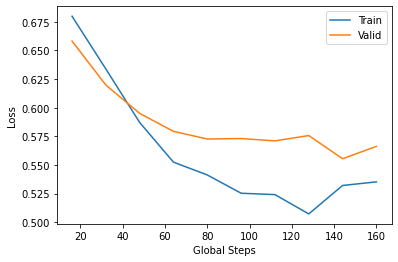

In [ ]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder+'/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /content/drive/My Drive/Colab Notebooks/Fake Real Tweets/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.9829    0.8594    0.9170      2816
           0     0.8766    0.9853    0.9277      2854

    accuracy                         0.9228      5670
   macro avg     0.9297    0.9223    0.9224      5670
weighted avg     0.9294    0.9228    0.9224      5670



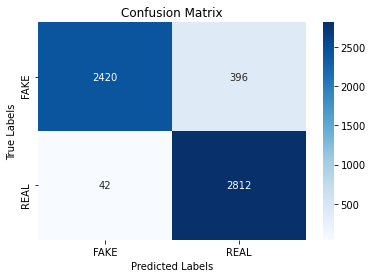

In [ ]:
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, title, text, titletext), _ in test_loader:

                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                titletext = titletext.type(torch.LongTensor)  
                titletext = titletext.to(device)
                output = model(titletext, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
    
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, test_iter)